In [12]:
import pandas as pd
import numpy as np

## Preparing the dataset for running the clustering model

We need to run a clystering model in order to cluster similar stores together. The similarity will be based:

Number of Transactions of each store

% Sales generated by each store for each family of products

In [ ]:
# Importing the datasets- Train, which contains the information of transactions for each store and item, and items, which
# contains the information of the items sold in all stores across Ecuador
# The train dataset contains 217 million rows, therefore it will take sometime to import the dataset

df = pd.read_csv("/Users/tehuttesfayebiru/Desktop/MCGILL/Program/Winter term/INSY 695/W1_Project/favorita-grocery-sales-forecasting/train.csv")

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# Checking if there are any missing values
df.isnull().sum()

For this analysis, the column 'onpromotion' is not important, therefore for now we decide to not take any action towards resolving the missing values that fall under this column

In [ ]:
# Also importing the items dataset, to join it with our main dataset to get the information about family of each item_nbr
items = pd.read_csv("/Users/tehuttesfayebiru/Desktop/MCGILL/Program/Winter term/INSY 695/W1_Project/favorita-grocery-sales-forecasting/items.csv")
items.head()

In [ ]:
items.info()

In [ ]:
# Checking for missing values
items.isnull().sum()

In [ ]:
# Checking the number of unique families of products
len(items['family'].unique())

In [ ]:
# Checking the number of items present under each family
items['family'].value_counts().plot(kind= 'barh', figsize = (7,7))

From the items dataset we see that there are 4100 unique products and they are categorized under 33 unique families

In [ ]:
# Merging df and items
df_with_items = pd.merge(df, items, on= 'item_nbr', how = 'inner')
df_with_items.head()

In [ ]:
# Saving df_with_items for future use
df_with_items.to_pickle('df_with_items')

In [ ]:
# Reading the pickle file- df_with_items
df_with_items = pd.read_pickle('df_with_items')

In [ ]:
df_with_items['date']= pd.to_datetime(df_with_items['date'])

In [ ]:
df_with_items[df_with_items['unit_sales'] < 0].groupby(['store_nbr','family'])['unit_sales'].sum().sort_values(ascending= True)

In [ ]:
# Calculating the total number of items sold for each store
items_sold = df_with_items[df_with_items['unit_sales'] > 0].groupby('store_nbr')['unit_sales'].sum()
# Resetting the index, which is the store number, as a column of the dataframe
items_sold = items_sold.reset_index()
# Renaming the unit_sales column to total_sales
items_sold = items_sold.rename(columns = {'unit_sales':'total_sales'})

In [ ]:
items_sold.head()

In [ ]:
# Calculating the total items sold for each store by family
items_sold_by_family = df_with_items[df_with_items['unit_sales'] > 0].groupby(['store_nbr', 'family'])['unit_sales'].sum()
# Resetting the columns in items_sold_by_family
items_sold_by_family = items_sold_by_family.reset_index(level= ['store_nbr', 'family'])
# Changing the name of unit_sales column to total_sales
items_sold_by_family = items_sold_by_family.rename(columns= {'unit_sales': 'total_sales_family'})

In [ ]:
items_sold_by_family.head()

In [ ]:
# Merging items_sold and items_sold_by_family in order to get all the information into a single dataframe and compute
# the percentage share of each family in each store

share_of_sales_by_fam = pd.merge(items_sold_by_family, 
                                 items_sold, 
                                 on= 'store_nbr', 
                                 how= 'inner')

In [ ]:
share_of_sales_by_fam.head()

In [ ]:
share_of_sales_by_fam['family'].unique()

In [ ]:
share_of_sales_by_fam.info()

It seems that some stores do not have products from all families, or it is all possible that the products from those families were never sold at those stores even if some inventory was maintained

In [ ]:
families_per_store = pd.DataFrame(share_of_sales_by_fam.groupby('store_nbr')['family'].count())

In [ ]:
families_per_store[families_per_store['family'] < 33]

In [ ]:
stores_per_family = pd.DataFrame(share_of_sales_by_fam.groupby('family')['store_nbr'].count())
stores_per_family[stores_per_family['store_nbr'] < 54]

The above four families are only sold at some stores. Therefore, while finding out the percentage share of sales of each family for each store, we will not group these families into 'Other' category even if their share of sales is very less.

In [ ]:
# Now calculating the share of sales of each family for each store
share_of_sales_by_fam['sales_share_family'] = (
    share_of_sales_by_fam['total_sales_family'] / share_of_sales_by_fam['total_sales'])*100

In [ ]:
# Sorting the values in the above dataframe
share_of_sales_by_fam = share_of_sales_by_fam.sort_values(['store_nbr', 'sales_share_family'], ascending= [True, False])
share_of_sales_by_fam.head()

In [ ]:
share_of_sales_by_fam[share_of_sales_by_fam['store_nbr'] == 1]['sales_share_family'].sum()

In [ ]:
# Grouping Grocery I and Grovery II as GROCERIES
share_of_sales_by_fam.loc[
    (share_of_sales_by_fam['family'] == 'GROCERY I') | 
    (share_of_sales_by_fam['family'] == 'GROCERY II'), 'family'] = 'GROCERIES'

In [ ]:
# Grouping Home and Kitchen I and Home and Kitchen II as HOME AND KITCHEN
share_of_sales_by_fam.loc[
    (share_of_sales_by_fam['family'] == 'HOME AND KITCHEN I') | 
    (share_of_sales_by_fam['family'] == 'HOME AND KITCHEN II'), 'family'] = 'HOME AND KITCHEN'

In [ ]:
# Calculating the sum of sales_share_family for each family
total_family_share = share_of_sales_by_fam.groupby('family')['sales_share_family'].sum().sort_values(ascending= False)
total_family_share = total_family_share.reset_index()
total_family_share

In [ ]:
# Joining share_of_sales_by_fam and total_family_share
share_of_sales_by_fam = pd.merge(share_of_sales_by_fam, 
                                 total_family_share, 
                                 on = 'family', 
                                 how = 'inner')

In [ ]:
share_of_sales_by_fam = share_of_sales_by_fam.rename(
    columns = {'sales_share_family_x': 'sales_share_family', 
               'sales_share_family_y': 'total_family_share_across_stores'})

In [ ]:
# Categorizing those families as 'Other' where the total_family_share_across_stores < 40%
list_of_families = list(
    share_of_sales_by_fam[share_of_sales_by_fam['total_family_share_across_stores'] < 40]['family'].unique())

In [ ]:
list_of_families

In [ ]:
# Removing the following families as they aren't sold at all stores, so if we include these 'OTHER' category would not be
# representative for all the stores
list_of_families.remove('LADIESWEAR')
list_of_families.remove('LAWN AND GARDEN')
list_of_families.remove('BOOKS')
list_of_families.remove('BABY CARE')

In [ ]:
# Adding 'EGGS' under 'OTHER' too, as the clustering model gives better results when we add 'EGGS' family to 'OTHER'
list_of_families.append('EGGS')

In [ ]:
list_of_families

In [ ]:
share_of_sales_by_fam.loc[share_of_sales_by_fam['family'].isin(list_of_families), 'family'] = 'OTHER'

In [ ]:
share_of_sales_by_fam['family'].value_counts()

In [ ]:
share_of_sales_by_fam.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\share_of_sales_by_family.csv")

In [ ]:
# Creating the final dataframe that will be used for clustering
final_df = pd.pivot_table(share_of_sales_by_fam, 
                          values= 'sales_share_family', 
                          index= 'store_nbr', 
                          columns= ['family'], aggfunc = np.sum)
# Resetting the index in order to add the store_nbr as column instead of having it as index
final_df = final_df.reset_index()

In [ ]:
final_df.head()

In [ ]:
# Checking if the sum of 'Others' worked 
share_of_sales_by_fam.loc[(share_of_sales_by_fam['family'] == 'OTHER') & (share_of_sales_by_fam['store_nbr'] == 2),'sales_share_family' ].sum()

In [ ]:
final_df.info()

In [ ]:
# Replacing the missing values with 0, as the missing values mean that those items are not sold in those stores
final_df = final_df.fillna(0)

In [ ]:
final_df.head()

In [ ]:
transactions = pd.read_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\Data Files\\transactions.csv")

In [ ]:
transactions.head()

In [ ]:
total_store_transactions = transactions.groupby('store_nbr')['transactions'].sum()
total_store_transactions = total_store_transactions.reset_index()
total_store_transactions.head()

In [ ]:
final_df = pd.merge(final_df, 
                    total_store_transactions, 
                    on = 'store_nbr', 
                    how= 'inner')
final_df.head()

In [ ]:
final_df = pd.merge(final_df, items_sold, on = 'store_nbr', how = 'inner')

In [ ]:
final_df.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\clustering_df.csv")

## Creating the clustering model

In [ ]:
final_df.head()

In [ ]:
# Dropping store_nbr
clustering_df = final_df.drop(columns= ['store_nbr', 'assigned_cluster'])

In [ ]:
clustering_df.head()

In [ ]:
clustering_df.columns

In [ ]:
from sklearn.cluster import KMeans
from scipy.stats import f
from sklearn.metrics import calinski_harabasz_score
from matplotlib import pyplot
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
import statistics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
clustering_df['transactions'] = scaler.fit_transform(clustering_df[['transactions']])
clustering_df['total_sales'] = scaler.fit_transform(clustering_df[['total_sales']])

In [ ]:
clustering_df.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\total_sales_scaled.csv")

In [ ]:
X = clustering_df[['CLEANING', 
                      'DAIRY', 
                      'GROCERIES',
                      'PRODUCE', 
                   'POULTRY',
                  'FROZEN FOODS',
                  'DELI',
                  'BREAD/BAKERY',
                  'total_sales',
                  'OTHER']]

In [ ]:
X_cols = list(X.columns)

In [ ]:
X_cols

In [ ]:
list_base_model = []
withinss=[]
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    model = kmeans.fit(X)
    labels = model.labels_
    withinss.append(model.inertia_)
    silhouette = silhouette_score(X, labels)
    list_base_model.append(silhouette)

In [ ]:
pyplot.plot(list(range(2,20)), withinss, marker= 'o')

In [ ]:
pyplot.plot(list(range(2,20)), list_base_model, marker= 'o')

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
model = kmeans.fit(X)
labels = model.labels_

In [ ]:
labels

In [ ]:
silhouette_sam = silhouette_samples(X, labels)

In [ ]:
df_100 = pd.DataFrame({'label':labels,'silhouette':silhouette_sam})
print('Average Silhouette Score for Cluster 0: ',np.average(df_100[df_100['label'] == 0].silhouette))
print('Average Silhouette Score for Cluster 1: ',np.average(df_100[df_100['label'] == 1].silhouette))
print('Average Silhouette Score for Cluster 2: ',np.average(df_100[df_100['label'] == 2].silhouette))
print('Average Silhouette Score for Cluster 3: ',np.average(df_100[df_100['label'] == 3].silhouette))

In [ ]:
cluster_centers_df = pd.DataFrame(model.cluster_centers_)

In [ ]:
cluster_centers_df.head()

In [ ]:
cluster_centers_df.columns = X_cols

In [ ]:
clustering_df['clusters'] = labels

In [ ]:
clustering_df['count'] =  1

In [ ]:
clustering_df.groupby('clusters')['total_sales','count'].sum()

In [ ]:
cluster_centers_df.head()

In [ ]:
# cluster_centers_df.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\cluster_centers.csv")

In [ ]:
# Adding the clusters column to the final_df
final_df['assigned_cluster'] = labels

In [ ]:
# final_df.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\clustering_df_with_assigned_clusters.csv")

In [ ]:
share_of_sales_by_fam[['store_nbr','total_sales']].drop_duplicates('store_nbr').sort_values('total_sales', ascending= False)

In [ ]:
df_unique = df_with_items.drop_duplicates(['date', 'store_nbr', 'item_nbr'])

In [ ]:
df_unique.shape

In [ ]:
df_with_items.shape

In [ ]:
len(df_with_items[(df_with_items['store_nbr'] == 1) & (df_with_items['date'] == '2013-01-02')]['item_nbr'].unique())

In [ ]:
df_with_items.head()

## Causal Inference Exploration

Question: What time of the year and where should a particular product be on-promotion?

For this, let us first find the list of products that were on promotion and how many times over the last 4-5 years.

Using the df_with_items, we filter those rows where we have the on-promotion information. Since each row is a unique 'date', 'store_nbr' and 'item_nbr' combination, therefore we find the rows where the products are on-promotion.

In [ ]:
df_onpromotion = df_with_items[df_with_items['onpromotion'] == 1]

In [ ]:
df_onpromotion = df_onpromotion.sort_values('date')

In [ ]:
df_onpromotion.head()

In [ ]:
df_onpromotion.info()

In [ ]:
df_onpromotion.groupby(['date', 'item_nbr'])['store_nbr'].count().reset_index()

In [ ]:
df_onpromotion.groupby(['date', 'item_nbr'])['store_nbr'].count().reset_index()['item_nbr'].nunique()

In [ ]:
# Lets check for the 5 most occuring item_nbr by date (i.e. the item which goes on promotion the most frequently).
# For this keep only the unique 'date' and 'item_nbr' combinations
df_onpromotion.drop_duplicates(['date', 'item_nbr']).groupby('item_nbr')['date'].count().sort_values(ascending= False)

In [ ]:
df_onpromotion.groupby(['date', 'item_nbr'])['store_nbr'].count().reset_index()['item_nbr'].value_counts()

In [ ]:
# Checking the families of item number 1167614 and item number 660


In [ ]:
# Lets pick item number 1392256 and check whether we have enough observations to perform causal inference for this product

In [ ]:
# Checking the number of observations of onpromotion = True that we have for item number 1392256
df_with_items[(df_with_items['onpromotion'] == 1) & (df_with_items['item_nbr'] == 1392256)]

In [ ]:
# Checking the number of observations of onpromotion = False that we have for item number 1392256
df_with_items[(df_with_items['onpromotion'] == 0) & (df_with_items['item_nbr'] == 1392256)]

In [ ]:
# Checking the number of observations where we do not know whether this product was onpromotion or not
df_with_items[(df_with_items['onpromotion'].isnull()) & (df_with_items['item_nbr'] == 1392256)]

In [ ]:
# So there are no observations for item number 1392256 where we don't know whether the item was on promotion or not,
# which makes it a good item to pick for for causal inference model

## Exploratory Analysis for Item Number: 1392256

In [13]:
# load causal dataframe
df_causal = pd.read_csv("/Users/tehuttesfayebiru/Desktop/MCGILL/Program/Winter term/INSY 695/W1_Project/df_causal.csv")
df_causal.head()

,Unnamed: 0,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
0,111736700,37761339,2014-12-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0
1,111736701,37838423,2014-12-21,1,1392256,14.0,False,HOME AND KITCHEN II,6350,0
2,111736702,37840329,2014-12-21,2,1392256,7.0,False,HOME AND KITCHEN II,6350,0
3,111736703,37868504,2014-12-21,23,1392256,2.0,False,HOME AND KITCHEN II,6350,0
4,111736704,37875069,2014-12-21,27,1392256,5.0,False,HOME AND KITCHEN II,6350,0


In [7]:
df_causal.columns

Index(['Unnamed: 0', 'id', 'date', 'store_nbr', 'item_nbr', 'unit_sales',
       'onpromotion', 'family', 'class', 'perishable'],
      dtype='object')

In [14]:
df_causal = df_causal.set_index('Unnamed: 0')
df_causal.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
Unnamed: 0,,,,,,,,,
111736700,37761339,2014-12-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0
111736701,37838423,2014-12-21,1,1392256,14.0,False,HOME AND KITCHEN II,6350,0
111736702,37840329,2014-12-21,2,1392256,7.0,False,HOME AND KITCHEN II,6350,0
111736703,37868504,2014-12-21,23,1392256,2.0,False,HOME AND KITCHEN II,6350,0
111736704,37875069,2014-12-21,27,1392256,5.0,False,HOME AND KITCHEN II,6350,0


In [10]:
# Creating a dataframe with only those observations that contain item_nbr = 1392256

#df_causal = df_with_items.loc[df_with_items['item_nbr'] == 1392256, ]

In [ ]:
# df_causal.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\df_causal.csv")

In [19]:
df_causal["item_nbr"].value_counts()

1392256    7573
Name: item_nbr, dtype: int64

In [ ]:
df_causal.head()

In [15]:
df_causal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7573 entries, 111736700 to 111744272
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           7573 non-null   int64  
 1   date         7573 non-null   object 
 2   store_nbr    7573 non-null   int64  
 3   item_nbr     7573 non-null   int64  
 4   unit_sales   7573 non-null   float64
 5   onpromotion  7573 non-null   bool   
 6   family       7573 non-null   object 
 7   class        7573 non-null   int64  
 8   perishable   7573 non-null   int64  
dtypes: bool(1), float64(1), int64(5), object(2)
memory usage: 539.9+ KB


In [16]:
# Checking when was the first sale recorded
df_causal['date'].min()

'2014-12-20'

In [17]:
# Checking when was the last sale recorded
df_causal['date'].max()

'2017-08-15'

In [ ]:
# Checking the unique dates when atleast one sale was recorded
df_causal.drop_duplicates('date').shape

So basically, the first time the product was sold on 20th December 2014 and since then to 8th August 2015, the product recorded a sale on 964 unique days. From 20th December 2014 to 15th August 2017, there are 969 days and out of those the product was sold on 964 days, so basically almost everyday atleast one unit of that product recorded a sale.

In [20]:
# Check which all stores is this item sold in
print("Stores in which item 1392256 is sold: ", df_causal['store_nbr'].unique())
print("Number of unique stores item 1392256 is sold in: ", df_causal['store_nbr'].nunique())

Stores in which item 1392256 is sold:  [ 1  2 23 27 24  3  8  7 37 26  5 25 38  4 41  6 46 44 45 53 51 47 50 48
 49 42]
Number of unique stores item 1392256 is sold in:  26


Thus, we now know that this item is sold in 26 out of the 54 stores. It can be possible that other stores also keep its inventory but that is highly unlikely given that we have 4 years of sales data, and it is very unlikely that a store would keep a product's inventory if it's not being sold

<AxesSubplot:ylabel='Unit Sales'>

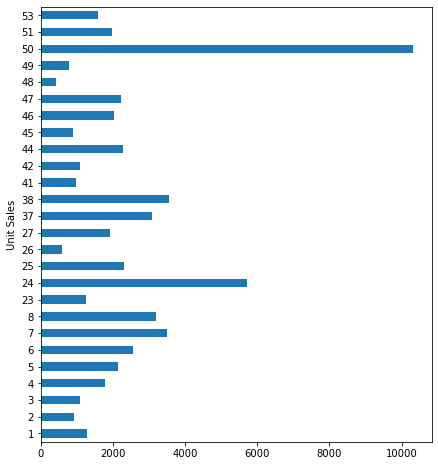

In [21]:
# Checking store wise sales of this product
df_causal.groupby('store_nbr')['unit_sales'].sum().plot(kind = 'barh', figsize = (7,8), ylabel = 'Store Number', xlabel = 'Unit Sales')

<AxesSubplot:xlabel='date'>

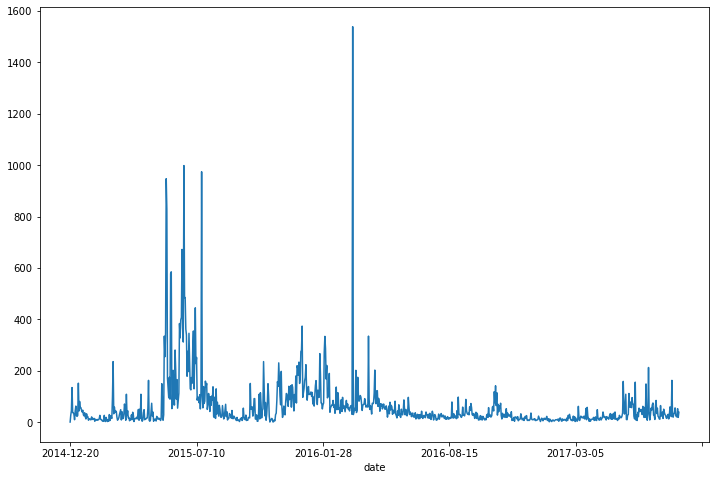

In [22]:
# Now lets check date wise what is the trend of sales

df_causal.groupby('date')['unit_sales'].sum().plot(kind = 'line', figsize = (12,8))

In [23]:
# Check month wise unit_sales trend from 2014 to 2017
trend = df_causal.groupby('date')['unit_sales'].sum().reset_index()

In [24]:
trend.index = pd.to_datetime(trend['date'], format = '%Y-%m-%d')

In [25]:
del trend['date']

In [26]:
month_wise_trend = trend.resample('M').sum()

<AxesSubplot:xlabel='Date', ylabel='Unit Sales'>

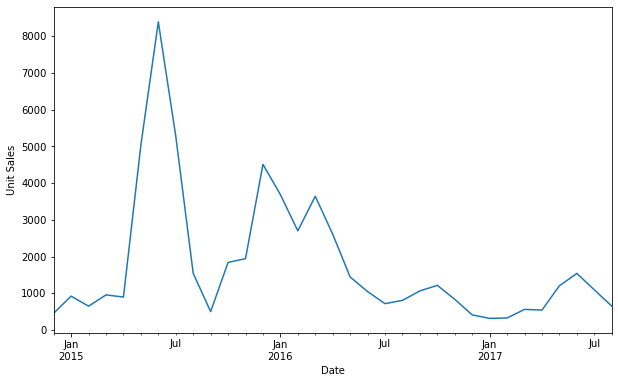

In [27]:
month_wise_trend['unit_sales'].plot(kind = 'line', figsize = (10,6), ylabel = 'Unit Sales', xlabel= 'Date')

Looks like after March 2016, the sales of this product dropped. In April 2016, there was a massive Earthquake in Equador.
It seems like after that earthquake the sales of this product never reached the values that were observed before the disaster

Lets plot bi-monthly

In [28]:
semi_month_end_trend = trend.resample('SM').sum()

<AxesSubplot:xlabel='date'>

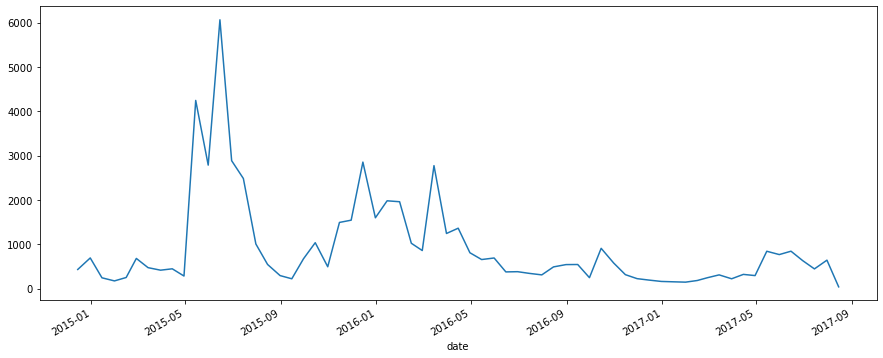

In [29]:
semi_month_end_trend['unit_sales'].plot(kind = 'line', figsize = (15,6))

In [30]:
semi_month_end_trend[28:40]

,unit_sales
date,
2016-02-15,1022.0
2016-02-29,858.0
2016-03-15,2773.0
2016-03-31,1243.0
2016-04-15,1362.0
2016-04-30,808.0
2016-05-15,655.0
2016-05-31,690.0
2016-06-15,376.0


As we can see that after April 30th, 2016, the sales for this product kept on dropping

In [34]:
# Now lets check in how many stores this product was sold and exactly on what dates
df_causal.groupby('date').agg({'store_nbr': 'count',
                              'unit_sales': 'sum'}).sort_values('unit_sales', ascending= False).rename(
    columns={'store_nbr' : 'count_of_stores', 'unit_sales': 'sum_of_unit_sales'})

,count_of_stores,sum_of_unit_sales
date,,
2016-03-15,13,1538.0
2015-06-20,18,998.0
2015-07-18,13,974.0
2015-05-23,15,947.0
2015-05-24,14,828.0
...,...,...
2015-04-02,2,3.0
2017-01-22,2,2.0
2015-11-03,1,1.0


In [35]:
# Lets check whether on 2015-06-20, this product was on promotion or not
df_causal[df_causal['date'] == '2015-06-20']

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
Unnamed: 0,,,,,,,,,
111738070,49399204,2015-06-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0
111738071,49401212,2015-06-20,2,1392256,2.0,True,HOME AND KITCHEN II,6350,0
111738072,49403448,2015-06-20,3,1392256,11.0,True,HOME AND KITCHEN II,6350,0
111738073,49407384,2015-06-20,5,1392256,90.0,True,HOME AND KITCHEN II,6350,0
111738074,49409439,2015-06-20,6,1392256,30.0,True,HOME AND KITCHEN II,6350,0
111738075,49411341,2015-06-20,7,1392256,10.0,True,HOME AND KITCHEN II,6350,0
111738076,49413457,2015-06-20,8,1392256,3.0,True,HOME AND KITCHEN II,6350,0
111738077,49434471,2015-06-20,24,1392256,8.0,True,HOME AND KITCHEN II,6350,0
111738078,49436059,2015-06-20,25,1392256,1.0,True,HOME AND KITCHEN II,6350,0


Analysing the above table, we can notice that on 2015-06-20, there are stores where the item is on promotion and then there are stores where the item is not on promotion

### Adding store information and holiday information to the dataframe

In [36]:
stores = pd.read_csv("/Users/tehuttesfayebiru/Desktop/MCGILL/Program/Winter term/INSY 695/W1_Project/favorita-grocery-sales-forecasting/stores.csv")

In [37]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [38]:
# Merging df_causal and stores
df_causal = pd.merge(df_causal, stores, on = 'store_nbr', how = 'left')

In [ ]:
# df_causal.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\df_causal_with_store.csv")

In [39]:
df_causal.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type,cluster
0,37761339,2014-12-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13
1,37838423,2014-12-21,1,1392256,14.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13
2,37840329,2014-12-21,2,1392256,7.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13
3,37868504,2014-12-21,23,1392256,2.0,False,HOME AND KITCHEN II,6350,0,Ambato,Tungurahua,D,9
4,37875069,2014-12-21,27,1392256,5.0,False,HOME AND KITCHEN II,6350,0,Daule,Guayas,D,1


In [40]:
df_causal.shape

(7573, 13)

In [ ]:
df_causal.isnull().sum()

In [41]:
# Lets check the number of cities each store selling item number 1392256 is present in
df_causal['city'].unique()

array(['Quito', 'Ambato', 'Daule', 'Guayaquil', 'Cuenca', 'Santo Domingo',
       'Salinas', 'Loja', 'Machala', 'Manta'], dtype=object)

In [42]:
# Lets check the number of stores that are in each city
df_causal.drop_duplicates(['store_nbr', 'city']).groupby('city')['store_nbr'].count()

city
Ambato            2
Cuenca            2
Daule             1
Guayaquil         3
Loja              1
Machala           1
Manta             1
Quito            13
Salinas           1
Santo Domingo     1
Name: store_nbr, dtype: int64

Most of the stores selling item 1392256 are located in Quito

In [43]:
# Lets check the distribution of stores state wise as well
df_causal.drop_duplicates(['store_nbr', 'state']).groupby('state')['store_nbr'].count()

state
Azuay                              2
El Oro                             1
Guayas                             4
Loja                               1
Manabi                             1
Pichincha                         13
Santa Elena                        1
Santo Domingo de los Tsachilas     1
Tungurahua                         2
Name: store_nbr, dtype: int64

In [44]:
# Importing the holidays dataframe
holidays = pd.read_csv("/Users/tehuttesfayebiru/Desktop/MCGILL/Program/Winter term/INSY 695/W1_Project/favorita-grocery-sales-forecasting/holidays_events.csv")

In [45]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [46]:
holidays['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [ ]:
holidays['type'].value_counts()

In [47]:
# Categorizing 'Additional', 'Transfer' and 'Bridge' as 'Holiday' as these three are also types of holidays
holidays.loc[(holidays['type'] == 'Additional') | 
              (holidays['type'] == 'Transfer') | 
              (holidays['type'] == 'Bridge'), 'type'] = 'Holiday'

In [48]:
holidays['type'].value_counts()

Holiday     289
Event        56
Work Day      5
Name: type, dtype: int64

In [ ]:
holidays = holidays.drop_duplicates('date')

In [49]:
# We only want those observations where it's either 'Holiday' or 'Event'
holidays_2 = holidays[holidays['type'].isin(['Holiday', 'Event'])]

In [50]:
holidays_2['type'].value_counts()

Holiday    289
Event       56
Name: type, dtype: int64

In [54]:
holidays_2

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Holiday,National,Ecuador,Navidad-3,False
346,2017-12-23,Holiday,National,Ecuador,Navidad-2,False
347,2017-12-24,Holiday,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [51]:
holidays_2['date'] = pd.to_datetime(holidays_2['date'])

<ipython-input-51-2af403c13ce7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_2['date'] = pd.to_datetime(holidays_2['date'])


In [56]:
df_causal['date'] = pd.to_datetime(df_causal['date'])

In [57]:
# Merging holidays_2 with df_causal on date

df_causal = pd.merge(df_causal, holidays_2, left_on = ['date'], right_on = ['date'], how = 'left')

In [58]:
df_causal.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,37761339,2014-12-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN,NaN
1,37838423,2014-12-21,1,1392256,14.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Navidad-4,False
2,37840329,2014-12-21,2,1392256,7.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Navidad-4,False
3,37868504,2014-12-21,23,1392256,2.0,False,HOME AND KITCHEN II,6350,0,Ambato,Tungurahua,D,9,Holiday,National,Ecuador,Navidad-4,False
4,37875069,2014-12-21,27,1392256,5.0,False,HOME AND KITCHEN II,6350,0,Daule,Guayas,D,1,Holiday,National,Ecuador,Navidad-4,False


In [60]:
df_causal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7741 entries, 0 to 7740
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            7741 non-null   int64         
 1   date          7741 non-null   datetime64[ns]
 2   store_nbr     7741 non-null   int64         
 3   item_nbr      7741 non-null   int64         
 4   unit_sales    7741 non-null   float64       
 5   onpromotion   7741 non-null   bool          
 6   family        7741 non-null   object        
 7   class         7741 non-null   int64         
 8   perishable    7741 non-null   int64         
 9   city          7741 non-null   object        
 10  state         7741 non-null   object        
 11  store_type    7741 non-null   object        
 12  cluster       7741 non-null   int64         
 13  holiday_type  1387 non-null   object        
 14  locale        1387 non-null   object        
 15  locale_name   1387 non-null   object  

In [59]:
df_causal = df_causal.rename(columns = {'type_x' : 'store_type', 'type_y' : 'holiday_type'})

In [63]:
df_causal.shape

(7741, 18)

In [61]:
df_causal.isnull().sum()

id                 0
date               0
store_nbr          0
item_nbr           0
unit_sales         0
onpromotion        0
family             0
class              0
perishable         0
city               0
state              0
store_type         0
cluster            0
holiday_type    6354
locale          6354
locale_name     6354
description     6354
transferred     6354
dtype: int64

In [64]:
df_causal.loc[df_causal['holiday_type'].isnull(), 'holiday_type'] = 'No Holiday'

In [65]:
df_causal['holiday_type'].value_counts()

No Holiday    6354
Holiday        985
Event          402
Name: holiday_type, dtype: int64

In [66]:
# Dropping locale, locale_name, description and transferred columns
df_causal_2 = df_causal.drop(columns = ['locale', 'locale_name', 'description', 'transferred'])

In [67]:
df_causal_2.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,state,store_type,cluster,holiday_type
0,37761339,2014-12-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13,No Holiday
1,37838423,2014-12-21,1,1392256,14.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13,Holiday
2,37840329,2014-12-21,2,1392256,7.0,False,HOME AND KITCHEN II,6350,0,Quito,Pichincha,D,13,Holiday


In [ ]:
# df_causal_2.to_csv("C:\\Users\\adity\\Documents\\Winter Semester'22 Courses MMA McGill\\Enterprise Data Science\\Group Project\\Data Files\\df_causal_with_store_and_holidays.csv")

## Preparing the dataset for the Causal ML model

In [68]:
causal = df_causal_2.join(pd.get_dummies(df_causal_2[['city', 'state', 'holiday_type']]))

In [69]:
causal.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,...,state_Guayas,state_Loja,state_Manabi,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_type_Event,holiday_type_Holiday,holiday_type_No Holiday
0,37761339,2014-12-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,0,1
1,37838423,2014-12-21,1,1392256,14.0,False,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,1,0
2,37840329,2014-12-21,2,1392256,7.0,False,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,1,0


In [70]:
# Dropping the following columns
# family
# perishable
# class
# state_Manabi
# holiday_type_Work Day
# city_Daule

causal = causal.drop(columns= ['family', 'perishable', 'class', 'state_Manabi', 'holiday_type_Work Day', 'city_Daule'])

KeyError: "['holiday_type_Work Day'] not found in axis"

In [71]:
causal.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,...,state_Guayas,state_Loja,state_Manabi,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_type_Event,holiday_type_Holiday,holiday_type_No Holiday
0,37761339,2014-12-20,1,1392256,1.0,False,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,0,1
1,37838423,2014-12-21,1,1392256,14.0,False,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,1,0
2,37840329,2014-12-21,2,1392256,7.0,False,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,1,0


In [72]:
# In the onpromotion column replacing False with 0 and True with 1

causal.loc[causal['onpromotion'] ==  False, 'onpromotion'] = 0
causal.loc[causal['onpromotion'] == True, 'onpromotion'] = 1

In [73]:
causal.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,...,state_Guayas,state_Loja,state_Manabi,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_type_Event,holiday_type_Holiday,holiday_type_No Holiday
0,37761339,2014-12-20,1,1392256,1.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,0,1
1,37838423,2014-12-21,1,1392256,14.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,1,0
2,37840329,2014-12-21,2,1392256,7.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,1,0,0,0,0,1,0


In [74]:
# Extracting year, month of the year, day of the month, day of the week
causal['year'] = pd.DatetimeIndex(causal['date']).year

In [75]:
causal['month'] = pd.DatetimeIndex(causal['date']).month

In [76]:
causal['day'] = causal['date'].dt.day

In [77]:
causal['day_of_week'] = causal['date'].dt.dayofweek

In [78]:
causal.head(2)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,...,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,holiday_type_Event,holiday_type_Holiday,holiday_type_No Holiday,year,month,day,day_of_week
0,37761339,2014-12-20,1,1392256,1.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,0,0,1,2014,12,20,5
1,37838423,2014-12-21,1,1392256,14.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,0,1,0,2014,12,21,6


In [79]:
# Also having stores as dummy variables
causal = causal.join(pd.get_dummies(causal['store_nbr'], drop_first= True, prefix = 'store_nbr'))

In [80]:
causal = causal.join(pd.get_dummies(causal['month'], drop_first= True))

In [81]:
causal = causal.join(pd.get_dummies(causal['day_of_week'], drop_first= True, prefix= 'day_of_week'))

In [83]:
causal = causal.join(pd.get_dummies(causal['day'], drop_first= True, prefix= 'day_of_month'))

In [84]:
causal.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,city,...,day_of_month_22,day_of_month_23,day_of_month_24,day_of_month_25,day_of_month_26,day_of_month_27,day_of_month_28,day_of_month_29,day_of_month_30,day_of_month_31
0,37761339,2014-12-20,1,1392256,1.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,0,0,0,0,0,0,0
1,37838423,2014-12-21,1,1392256,14.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,0,0,0,0,0,0,0
2,37840329,2014-12-21,2,1392256,7.0,0,HOME AND KITCHEN II,6350,0,Quito,...,0,0,0,0,0,0,0,0,0,0
3,37868504,2014-12-21,23,1392256,2.0,0,HOME AND KITCHEN II,6350,0,Ambato,...,0,0,0,0,0,0,0,0,0,0
4,37875069,2014-12-21,27,1392256,5.0,0,HOME AND KITCHEN II,6350,0,Daule,...,0,0,0,0,0,0,0,0,0,0


In [86]:
list(causal.columns)

['id',
 'date',
 'store_nbr',
 'item_nbr',
 'unit_sales',
 'onpromotion',
 'family',
 'class',
 'perishable',
 'city',
 'state',
 'store_type',
 'cluster',
 'holiday_type',
 'city_Ambato',
 'city_Cuenca',
 'city_Daule',
 'city_Guayaquil',
 'city_Loja',
 'city_Machala',
 'city_Manta',
 'city_Quito',
 'city_Salinas',
 'city_Santo Domingo',
 'state_Azuay',
 'state_El Oro',
 'state_Guayas',
 'state_Loja',
 'state_Manabi',
 'state_Pichincha',
 'state_Santa Elena',
 'state_Santo Domingo de los Tsachilas',
 'state_Tungurahua',
 'holiday_type_Event',
 'holiday_type_Holiday',
 'holiday_type_No Holiday',
 'year',
 'month',
 'day',
 'day_of_week',
 'store_nbr_2',
 'store_nbr_3',
 'store_nbr_4',
 'store_nbr_5',
 'store_nbr_6',
 'store_nbr_7',
 'store_nbr_8',
 'store_nbr_23',
 'store_nbr_24',
 'store_nbr_25',
 'store_nbr_26',
 'store_nbr_27',
 'store_nbr_37',
 'store_nbr_38',
 'store_nbr_41',
 'store_nbr_42',
 'store_nbr_44',
 'store_nbr_45',
 'store_nbr_46',
 'store_nbr_47',
 'store_nbr_48',
 'sto

In [87]:
# drop dummified columns
causal = causal.drop(columns= ['month', 'day', 'day_of_week', 'store_nbr'])

In [88]:
# change month column names
causal = causal.rename(columns = {'2':'month_2','3':'month_3', '4':'month_4', 
                                 '5':'month_5', '6':'month_6', '7':'month_7',
                                 '8':'month_8', '10':'month_10', '11':'month_11',
                                 '12':'month_12'})

In [89]:
list(causal.columns)

['id',
 'date',
 'item_nbr',
 'unit_sales',
 'onpromotion',
 'family',
 'class',
 'perishable',
 'city',
 'state',
 'store_type',
 'cluster',
 'holiday_type',
 'city_Ambato',
 'city_Cuenca',
 'city_Daule',
 'city_Guayaquil',
 'city_Loja',
 'city_Machala',
 'city_Manta',
 'city_Quito',
 'city_Salinas',
 'city_Santo Domingo',
 'state_Azuay',
 'state_El Oro',
 'state_Guayas',
 'state_Loja',
 'state_Manabi',
 'state_Pichincha',
 'state_Santa Elena',
 'state_Santo Domingo de los Tsachilas',
 'state_Tungurahua',
 'holiday_type_Event',
 'holiday_type_Holiday',
 'holiday_type_No Holiday',
 'year',
 'store_nbr_2',
 'store_nbr_3',
 'store_nbr_4',
 'store_nbr_5',
 'store_nbr_6',
 'store_nbr_7',
 'store_nbr_8',
 'store_nbr_23',
 'store_nbr_24',
 'store_nbr_25',
 'store_nbr_26',
 'store_nbr_27',
 'store_nbr_37',
 'store_nbr_38',
 'store_nbr_41',
 'store_nbr_42',
 'store_nbr_44',
 'store_nbr_45',
 'store_nbr_46',
 'store_nbr_47',
 'store_nbr_48',
 'store_nbr_49',
 'store_nbr_50',
 'store_nbr_51',
 '

## Creating the Causal ML model

In [90]:
X = causal.drop(columns= ['id', 
                          'date',  
                          'item_nbr', 
                          'city', 
                          'state', 
                          'store_type', 
                          'cluster', 
                          'unit_sales', 
                         'onpromotion',
                         'holiday_type'])

In [91]:
y = causal['unit_sales']

In [92]:
treatment = causal['onpromotion']

In [93]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/Users/tehuttesfayebiru/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/tehuttesfayebiru/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [95]:
! pip install causalml

     |████████████████████████████████| 406 kB 228 kB/s eta 0:00:01
  Using cached pydotplus-2.0.2-py3-none-any.whl
  Using cached shap-0.37.0.tar.gz (326 kB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached lightgbm-3.3.2-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.2 MB)
  Using cached pygam-0.8.0-py2.py3-none-any.whl (1.8 MB)
  Using cached pyro_ppl-1.8.0-py3-none-any.whl (713 kB)
  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)
  ERROR: Command errored out with exit status 1:
   command: /Users/tehuttesfayebiru/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-install-vgij3pkf/causalml_785b9df12fa244b6ba616921a78fe97c/setup.py'"'"'; __file__='"'"'/private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-install-vgij3pkf/causalml_785b9df12fa244b6ba616921a78fe97c/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);c

  ERROR: Command errored out with exit status 1:
   command: /Users/tehuttesfayebiru/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-install-vgij3pkf/shap_a55ed4a3e6ba471b9dad840174d5efba/setup.py'"'"'; __file__='"'"'/private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-install-vgij3pkf/shap_a55ed4a3e6ba471b9dad840174d5efba/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-wheel-s9_10g1m
       cwd: /private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-install-vgij3pkf/shap_a55ed4a3e6ba471b9dad840174d5efba/
  Complete output (96 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.macosx-10.9-x86_64-3.8
  creating build/lib.macos

Failed to build causalml shap
    Running setup.py install for shap ... error
    ERROR: Command errored out with exit status 1:
     command: /Users/tehuttesfayebiru/opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-install-vgij3pkf/shap_a55ed4a3e6ba471b9dad840174d5efba/setup.py'"'"'; __file__='"'"'/private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-install-vgij3pkf/shap_a55ed4a3e6ba471b9dad840174d5efba/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip-record-wnw29zxn/install-record.txt --single-version-externally-managed --compile --install-headers /Users/tehuttesfayebiru/opt/anaconda3/include/python3.8/shap
         cwd: /private/var/folders/zy/5dhf499j2nq6jsnb4h5wg0080000gn/T/pip

In [94]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from sklearn.impute import SimpleImputer

ModuleNotFoundError: No module named 'causalml'

In [ ]:
# Computing the Average Treatment Effect (ATE)

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

In [ ]:
CATE_T = xg.fit_predict(X, treatment,y)

In [ ]:
df_CATE = causal.copy()

In [ ]:
df_CATE['CATE'] = CATE_T

In [ ]:
df_CATE.groupby('store_nbr')['CATE'].sum().reset_index().sort_values('CATE')

In [ ]:
df_CATE[df_CATE['year'].isin([2016, 2017])].groupby('month')['CATE'].sum().sort_values()

In [ ]:
df_year_month = df_CATE.groupby(['year', 'month'])['CATE'].sum().reset_index()

In [ ]:
df_year_month[df_year_month['year'] == 2015].sort_values('CATE', ascending= False)

In [ ]:
df_year_month[df_year_month['year'] == 2016].sort_values('CATE', ascending= False)

In [ ]:
df_year_month[df_year_month['year'] == 2017].sort_values('CATE', ascending= False)

In [ ]:
df_store_month = df_CATE[df_CATE['year'].isin([2016,2017])].groupby(['store_nbr', 'month'])['CATE'].sum().reset_index()

In [ ]:
df_store_month[df_store_month['store_nbr'] == 1]

In [ ]:
df_store_month[df_store_month['store_nbr'] == 2]

In [ ]:
df_store_month[df_store_month['store_nbr'] == 3]

In [ ]:
df_store_month[df_store_month['store_nbr'] == 4]

In [ ]:
df_store_month[df_store_month['store_nbr'] == 5]